In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (201 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import cv2
from google.colab.patches import cv2_imshow
import pathlib
from tensorflow.keras import datasets, layers, models
from keras.models import Model, load_model, Sequential
from sklearn.metrics import precision_score, recall_score,accuracy_score,  f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [ ]:
from sklearn.metrics import precision_score, recall_score,accuracy_score,  f1_score, roc_auc_score, roc_curve

In [ ]:
MAGNIFICATION_LEVEL_A = 4
MAGNIFICATION_LEVEL_B = 3
IMG_SIZE = 299
STRIDE = 100
CENTER_IMAGE = 128

# Generating patches for training and testing using sliding window approach

## Mounting drive and defining functions

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')

!cat '/gdrive/My Drive/foo.txt'

Mounted at /gdrive
Hello Google Drive!

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels =  list(zip(indices[0], indices[1]))
    percent_tissue = len(tissue_pixels) / float(image.shape[0] * image.shape[0]) * 100
    return percent_tissue

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def find_tumor_percentage(image):
    mask_image = image[:,:,0]
    assert mask_image.shape == (image.shape[0], image.shape[1])
    # if the pixel has value 1 then it is a tumor
    percent_tumor = np.count_nonzero(mask_image) / float(image.shape[0]*image.shape[1]) * 100
    return percent_tumor

In [ ]:
#defining constants 
drive_data  = '/gdrive/MyDrive/stored_slides/'

In [ ]:
def create_images_from_slides(tissue_file, mask_file, magnification_level_a = MAGNIFICATION_LEVEL_A , magnification_level_b = MAGNIFICATION_LEVEL_B):
 drive_data_tumor  = drive_data+ tissue_file +'.tif'
 drive_data_mask  =  drive_data+ mask_file +'.tif'

 cancerous_m_a , non_cancerous_m_a , cancerous_m_b , non_cancerous_m_b = [] , [],[] , []
 cancerous_label , non_cancerous_label = [] ,  []

 #opening the slide and its mask to read
 slide = open_slide(drive_data_tumor)
 slide_mask = open_slide(drive_data_mask)

 #parameters for magnification level a
 downsample_size_a = int(slide.level_downsamples[magnification_level_a])
 slide_width_a = slide.level_dimensions[magnification_level_a][0]
 slide_height_a = slide.level_dimensions[magnification_level_a][1]


 for x in range(0,slide_width_a - IMG_SIZE , STRIDE):
  for y in range(0,slide_height_a - IMG_SIZE , STRIDE): 
   #finding the tumor percentage to remove classify cancerous_m_a and non cancerous_m_a cells
   mask_image = read_slide(slide_mask, x = x*downsample_size_a, y = y*downsample_size_a, level=magnification_level_a,  width=IMG_SIZE,  height=IMG_SIZE)    
   #finding the center patch of the mask image to use for classification
   offset = int((mask_image.shape[0]-CENTER_IMAGE)/2)
   center_mask_image = mask_image[offset:offset+CENTER_IMAGE, offset:offset+CENTER_IMAGE]
  
   tumor_percentage = find_tumor_percentage(center_mask_image)
	
   #finding tissue percentage to remove the gray scale area
   slide_image_a = read_slide(slide, x = x*downsample_size_a, y = y*downsample_size_a, level=magnification_level_a, width=IMG_SIZE, height=IMG_SIZE)
   percentage_tissue = find_tissue_pixels(slide_image_a)

   if percentage_tissue > 20:
    slide_image_b = read_slide(slide, x = x*downsample_size_a, y = y*downsample_size_a, level=magnification_level_b, width=IMG_SIZE, height=IMG_SIZE)

    if tumor_percentage > 1:
     cancerous_m_a.append(slide_image_a)     
     cancerous_m_b.append(slide_image_b)
    
     cancerous_label.append(1)
    else:
     non_cancerous_m_a.append(slide_image_a)
     non_cancerous_m_b.append(slide_image_b)

     non_cancerous_label.append(0) 

 return cancerous_m_a , cancerous_label, non_cancerous_m_a , non_cancerous_label , cancerous_m_b , non_cancerous_m_b 

In [ ]:
def generate_patches_from_slides_arr(slides_arr):
  cancerous_arr_a , cancerous_label_arr, non_cancerous_arr_a , non_cancerous_label_arr = [] ,[] , [] ,[] 
  cancerous_arr_b , non_cancerous_arr_b  = [] ,[] 

  for s in slides_arr : 
    cancerous_m_a , cancerous_label , non_cancerous_m_a , non_cancerous_label , cancerous_m_b, non_cancerous_m_b  = create_images_from_slides(tissue_file = s ,mask_file= s +'_mask')

    cancerous_arr_a.extend(cancerous_m_a)
    cancerous_label_arr.extend(cancerous_label)
    non_cancerous_arr_a.extend(non_cancerous_m_a)
    non_cancerous_label_arr.extend(non_cancerous_label)

    cancerous_arr_b.extend(cancerous_m_b)
    non_cancerous_arr_b.extend(non_cancerous_m_b)

  return cancerous_arr_a , cancerous_label_arr, non_cancerous_arr_a , non_cancerous_label_arr , cancerous_arr_b , non_cancerous_arr_b

## Generating data 

Training data generation

In [ ]:
#Generate the files using image names 

slides_for_training_model = ['tumor_101','tumor_110','tumor_094','tumor_078','tumor_031']
cancerous_arr_a , cancerous_label_arr, non_cancerous_arr_a , non_cancerous_label_arr ,cancerous_arr_b , non_cancerous_arr_b = generate_patches_from_slides_arr(slides_for_training_model)

Test data generation


In [ ]:
slides_for_testing_model = ['tumor_091','tumor_084','tumor_016']
cancerous_arr_a_test , cancerous_label_arr_test, non_cancerous_arr_a_test , non_cancerous_label_arr_test ,cancerous_arr_b_test , non_cancerous_arr_b_test  = generate_patches_from_slides_arr(slides_for_testing_model)

In [ ]:
test_arr_magn_a = cancerous_arr_a_test +non_cancerous_arr_a_test
test_arr_magn_b = cancerous_arr_b_test +non_cancerous_arr_b_test
test_labels = cancerous_label_arr_test + non_cancerous_label_arr_test

In [ ]:
assert(len(test_arr_magn_a)==len(test_labels))
assert(len(test_arr_magn_b)==len(test_labels))

# Under Sampling and Shuffling the training data

Shuffling the non cancerous samples of both magnification level 'a' and 'b'

In [ ]:
non_cancerous_arr_a = shuffle(non_cancerous_arr_a, random_state=23)
non_cancerous_arr_b = shuffle(non_cancerous_arr_b ,  random_state=23)

In [ ]:
num_cancer_samples = len(cancerous_arr_a)
print('Number of cancer samples',num_cancer_samples)

Number of cancer samples 1557


Merging cancerous and non cancerous labels so thhat they gace equal number

In [ ]:
magn_a_samples = non_cancerous_arr_a[:num_cancer_samples] + cancerous_arr_a
magn_b_samples = non_cancerous_arr_b[:num_cancer_samples] + cancerous_arr_b
labels = non_cancerous_label_arr[:num_cancer_samples] + cancerous_label_arr

In [ ]:
magn_a_samples = shuffle(magn_a_samples, random_state=23)
magn_b_samples = shuffle(magn_b_samples, random_state=23)
labels = shuffle(labels, random_state=23)

## Sanity checks and visualization same image generated on both magnification level

In [ ]:
assert(len(magn_a_samples)==2*num_cancer_samples)
assert(len(magn_b_samples)==2*num_cancer_samples)

#making sure the class labels are balanced
assert((sum(labels)/len(labels)) == 0.5)

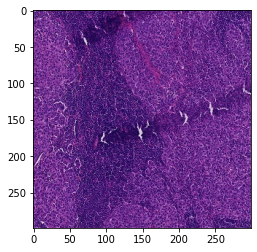

In [ ]:
plt.imshow(magn_a_samples[300])

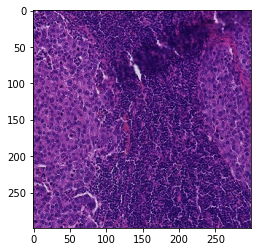

In [ ]:
plt.imshow(magn_b_samples[300])

# Model Prediction

In [ ]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

## Non fine tuned inception model

In [ ]:
inception1  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))
inception2  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))


for layer in inception2.layers:
 layer._name = layer.name + str("inception_2")

87916544/87910968 [==============================] - 0s 0us/step


Credits - https://www.tensorflow.org/guide/keras/functional#a_toy_resnet_model 

In [ ]:
input_arr_1 = inception1.input
input_arr_2 = inception2.input

output_arr_1 = inception1.output
output_arr_2 = inception2.output


concat = layers.concatenate([output_arr_1, output_arr_2])


f = layers.Flatten()(concat)
d = layers.Dense(128, activation='relu')(f)
output = layers.Dense(1, activation='sigmoid')(d)

# call model
multi_magnification_model = Model([input_arr_1, input_arr_2], output)

In [ ]:
multi_magnification_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
f = np.array(magn_a_samples)
g = np.array(magn_b_samples)
h = np.array(labels)

history = multi_magnification_model.fit([f,g], h, batch_size=64, epochs=10 , validation_split=0.2)

Epoch 1/10
39/39 [==============================] - 84s 2s/step - loss: 0.7319 - accuracy: 0.7656 - val_loss: 452333952.0000 - val_accuracy: 0.5040
Epoch 2/10
39/39 [==============================] - 70s 2s/step - loss: 0.6318 - accuracy: 0.8671 - val_loss: 1.6539 - val_accuracy: 0.5104
Epoch 3/10
39/39 [==============================] - 70s 2s/step - loss: 0.4416 - accuracy: 0.8366 - val_loss: 209.8949 - val_accuracy: 0.7657
Epoch 4/10
39/39 [==============================] - 70s 2s/step - loss: 0.2791 - accuracy: 0.9008 - val_loss: 9.9695 - val_accuracy: 0.8555
Epoch 5/10
39/39 [==============================] - 70s 2s/step - loss: 0.1964 - accuracy: 0.9193 - val_loss: 29.7826 - val_accuracy: 0.8555
Epoch 6/10
39/39 [==============================] - 70s 2s/step - loss: 0.1556 - accuracy: 0.9314 - val_loss: 0.1928 - val_accuracy: 0.9069
Epoch 7/10
39/39 [==============================] - 70s 2s/step - loss: 0.1103 - accuracy: 0.9494 - val_loss: 0.1636 - val_accuracy: 0.9422
Epoch 8/1

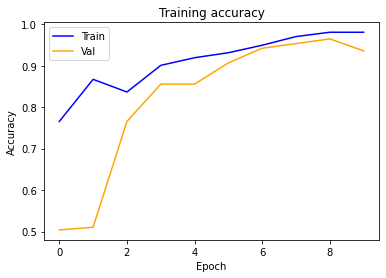

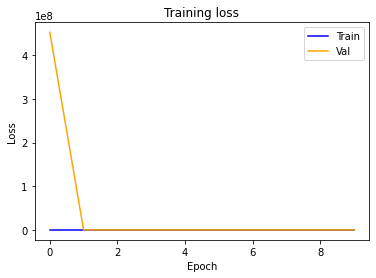

In [ ]:
plot(history)

In [ ]:
multi_magnification_model.save("/gdrive/MyDrive/multi_magnification_model.h5")


## Fine Tuned Inception Model

In [ ]:
inception1_fine_tuned  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))
inception2_fine_tuned  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))


for layer in inception2_fine_tuned.layers:
 layer._name = layer.name + str("inception_2")

Credits - https://www.tensorflow.org/guide/keras/functional#a_toy_resnet_model 

In [ ]:
#fine tuning the model
inception1_fine_tuned.trainable = True
inception2_fine_tuned.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception1_fine_tuned.layers))

# Fine-tune from this layer onwards
fine_tune_at = 270

# Freeze all the layers before the `fine_tune_at` layer
for layer in inception1_fine_tuned.layers[:fine_tune_at]:
  layer.trainable =  False

for layer in inception2_fine_tuned.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  311


Defining the custom model

In [ ]:
input_arr_1 = inception1_fine_tuned.input
input_arr_2 = inception2_fine_tuned.input

output_arr_1 = inception1_fine_tuned.output
output_arr_2 = inception2_fine_tuned.output


concat = layers.concatenate([output_arr_1, output_arr_2])


f = layers.Flatten()(concat)
d = layers.Dense(128, activation='relu')(f)
output = layers.Dense(1, activation='sigmoid')(d)

# call model
fine_tuned_multi_magnification_model = Model([input_arr_1, input_arr_2], output)

In [ ]:
fine_tuned_multi_magnification_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
f = np.array(magn_a_samples)
g = np.array(magn_b_samples)
h = np.array(labels)

history = fine_tuned_multi_magnification_model.fit([f,g], h, batch_size=64, epochs=10 , validation_split=0.2)

Epoch 1/10
39/39 [==============================] - 36s 709ms/step - loss: 18.1256 - accuracy: 0.6448 - val_loss: 16.6936 - val_accuracy: 0.6597
Epoch 2/10
39/39 [==============================] - 24s 628ms/step - loss: 0.4526 - accuracy: 0.8485 - val_loss: 2.3153 - val_accuracy: 0.7496
Epoch 3/10
39/39 [==============================] - 24s 616ms/step - loss: 0.2884 - accuracy: 0.8949 - val_loss: 0.6768 - val_accuracy: 0.8347
Epoch 4/10
39/39 [==============================] - 24s 618ms/step - loss: 0.3371 - accuracy: 0.8880 - val_loss: 0.8094 - val_accuracy: 0.8395
Epoch 5/10
39/39 [==============================] - 24s 622ms/step - loss: 0.2954 - accuracy: 0.8902 - val_loss: 0.4525 - val_accuracy: 0.8539
Epoch 6/10
39/39 [==============================] - 24s 620ms/step - loss: 0.1795 - accuracy: 0.9364 - val_loss: 0.4351 - val_accuracy: 0.8716
Epoch 7/10
39/39 [==============================] - 24s 619ms/step - loss: 0.1034 - accuracy: 0.9604 - val_loss: 0.3841 - val_accuracy: 0.89

In [ ]:
fine_tuned_multi_magnification_model.save("/gdrive/MyDrive/fine_tuned_multi_magnification_model.h5")

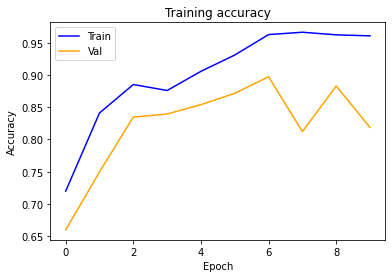

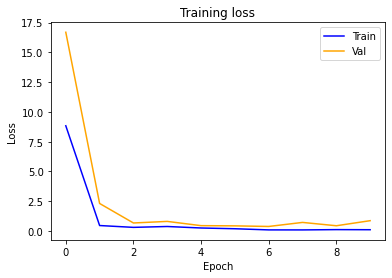

In [ ]:
plot(history)

# Testing metrics and heat map generation

In [ ]:
def print_metrics_on_test_data(model , test_images_magn_a ,test_images_magn_b , test_labels):
  predicted_test_labels = []

  for i in range (0 , len(test_labels)):
    test_image_a = tf.expand_dims(np.asarray(test_images_magn_a[i]), axis=0)
    test_image_b = tf.expand_dims(np.asarray(test_images_magn_b[i]), axis=0)
    #passing images for both magnification level for  prediction
    test_prediction = model.predict([test_image_a,test_image_b])
    # calculating label based on probability threshhold
    test_pred = 0 
    if test_prediction[0][0] >= 0.5:
      test_pred = 1

    predicted_test_labels.append(test_pred)
    
  accuracy= accuracy_score(test_labels,predicted_test_labels)
  recall= recall_score(test_labels,predicted_test_labels)
  f1= f1_score(test_labels,predicted_test_labels)
  auc= roc_auc_score(test_labels,predicted_test_labels)

  print('accuracy ',accuracy)
  print('recall ',recall)
  print('f1 ',f1)
  print('auc ',auc)


In [ ]:
print_metrics_on_test_data(multi_magnification_model,test_arr_magn_a, test_arr_magn_b, test_labels )

accuracy  0.7678774120317821
recall  0.9024390243902439
f1  0.4749679075738126
auc  0.8262997947898555


In [ ]:
print_metrics_on_test_data(fine_tuned_multi_magnification_model,test_arr_magn_a, test_arr_magn_b, test_labels)

accuracy  0.6362088535754824
recall  0.7219512195121951
f1  0.31590181430096054
auc  0.6734354684587309


## Functions for generating heatmap

In [ ]:
def generate_heat_map_mask(passed_model, tissue_file, magnification_level_a = MAGNIFICATION_LEVEL_A , magnification_level_b = MAGNIFICATION_LEVEL_B ):
 drive_data_tumor  = drive_data+ tissue_file +'.tif'

 #opening the slide and its mask to read
 slide = open_slide(drive_data_tumor)

 #parameters for magnification level a
 downsample_size_a = int(slide.level_downsamples[magnification_level_a])
 slide_width_a = slide.level_dimensions[magnification_level_a][0]
 slide_height_a = slide.level_dimensions[magnification_level_a][1]

 mask = np.full(shape= (slide_height_a, slide_width_a), fill_value= 0)

 for x in range(0,slide_width_a - IMG_SIZE , IMG_SIZE):
  for y in range(0,slide_height_a - IMG_SIZE , IMG_SIZE): 
   #finding tissue percentage to remove the gray scale area
   slide_image_a = read_slide(slide, x = x*downsample_size_a, y = y*downsample_size_a, level=magnification_level_a, width=IMG_SIZE, height=IMG_SIZE)
   percentage_tissue = find_tissue_pixels(slide_image_a)

   if percentage_tissue > 20:
    slide_image_b = read_slide(slide, x = x*downsample_size_a, y = y*downsample_size_a, level=magnification_level_b, width=IMG_SIZE, height=IMG_SIZE)

    test_image_a = tf.expand_dims(np.asarray(slide_image_a), axis=0)
    test_image_b = tf.expand_dims(np.asarray(slide_image_b), axis=0)
    test_prediction = passed_model.predict([test_image_a,test_image_b])
    
    # calculating label based on probability threshhold
    test_pred = 0 
    if test_prediction[0][0] >= 0.5:
      test_pred = 1

    if test_pred==1 :  ## cancerous is 1
        mask[x:x+IMG_SIZE, y:y+IMG_SIZE] = 1
    else:
        continue

 return mask 

In [ ]:
def show_image_with_original_mask_on(tumor_slide_name , magnification_level = 6):
  drive_data_tumor  = drive_data+ tumor_slide_name+'.tif'
  drive_data_mask  =  drive_data+ tumor_slide_name+'_mask.tif'

  slide = open_slide(drive_data_tumor)
  slide_mask = open_slide(drive_data_mask)

  slide_image = read_slide(slide,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])
  mask_image = read_slide(slide_mask,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])
  mask_image = mask_image[:,:,0]

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
def model_show_image_with_mask_on(model , tumor_slide_name, magnification_level = MAGNIFICATION_LEVEL_A):
  mask_image = generate_heat_map_mask(model , tumor_slide_name)

  drive_data_tumor  = drive_data+ tumor_slide_name+'.tif'

  slide = open_slide(drive_data_tumor)
  slide_image = read_slide(slide,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

# Heat map ground truth and prediction with different models

## tumor_091

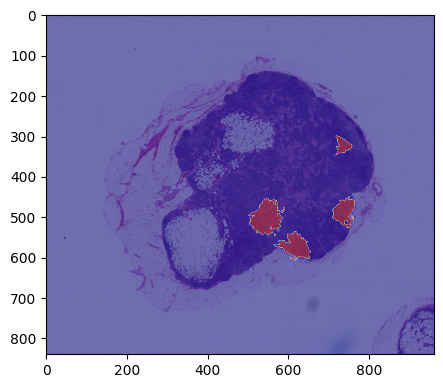

In [ ]:
#ground truth 
show_image_with_original_mask_on('tumor_091')

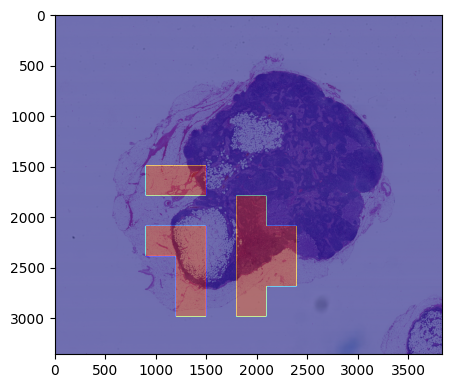

In [ ]:
model_show_image_with_mask_on(multi_magnification_model , 'tumor_091')

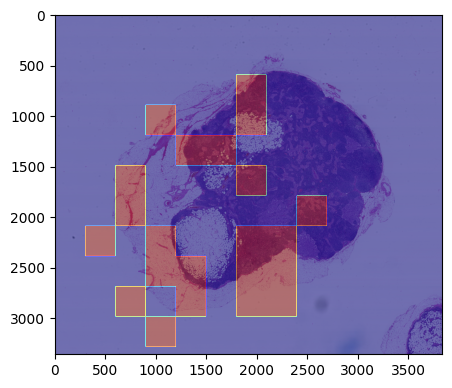

In [ ]:
model_show_image_with_mask_on(fine_tuned_multi_magnification_model , 'tumor_091')

## tumor_084

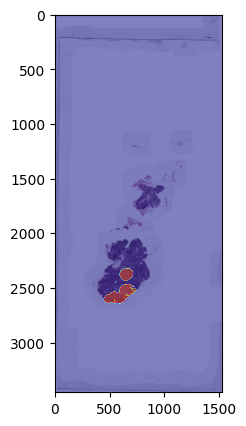

In [ ]:
#ground truth 
show_image_with_original_mask_on('tumor_016')

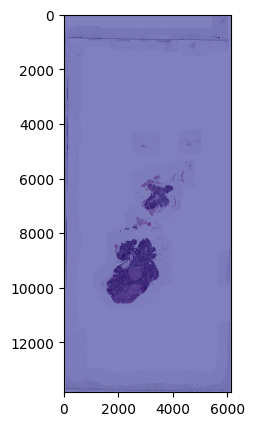

In [ ]:
model_show_image_with_mask_on(fine_tuned_multi_magnification_model , 'tumor_016')

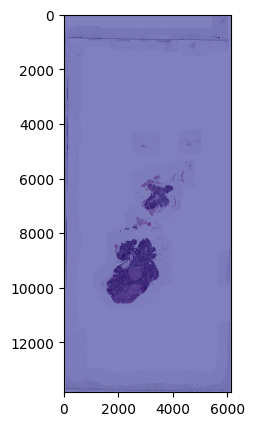

In [ ]:
model_show_image_with_mask_on(multi_magnification_model , 'tumor_016')